<a href="https://colab.research.google.com/github/vasudevan-gomathy/CaseStudy_UserAdoption/blob/main/CaseStudy_UserAdoption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict User Adoption

In [1]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import scipy.stats
import matplotlib.dates as mdates
import plotly.graph_objects as go
plt.style.use('bmh')

**Importing Dataset**

In [2]:
# Checking the encoding of the csv files
with open('/content/takehome_users.csv') as f:
    print(f)
    #for text in f:
        #print(text)
with open('/content/takehome_user_engagement.csv') as f:
    print(f)

<_io.TextIOWrapper name='/content/takehome_users.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/takehome_user_engagement.csv' mode='r' encoding='UTF-8'>


In [5]:
# Importing the csv file into a dataframe using the above encoding

# load as Pandas dataframe
users = pd.read_csv('/content/takehome_users.csv', parse_dates = ['creation_time'], 
                    encoding = "cp1252")
user_eng = pd.read_csv('/content/takehome_user_engagement.csv',  parse_dates = ['time_stamp'], 
                       encoding = "cp1252")

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [7]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04


In [8]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


**Converting the last_session_creation_time column in the users column to datetime.**

In [10]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'] ,unit='s')
users.last_session_creation_time.dtypes
users['last_session_creation_time'].min(), users['last_session_creation_time'].max()
users['creation_time'].min(), users['creation_time'].max()

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))

**For determining which users can be labeled as adopted users, we can use groupby and rolling methods to find the users who were active for more than 3 days in any of the 7 day rolling period.**

In [11]:
df = user_eng.copy()
df['date'] = pd.to_datetime(df.time_stamp.dt.date)
def rolling_count(df_group, frequency):
    return df_group.rolling(frequency, on='date')['user_id'].count()
df['visits_7_days'] = df.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
visits_7_days,207917.0,4.381393,2.042666,1.0,3.0,4.0,6.0,7.0


In [12]:
df[df.visits_7_days >= 3.0]

,time_stamp,user_id,visited,date,visits_7_days
9,2014-02-09 03:45:04,2,1,2014-02-09,3.0
10,2014-02-13 03:45:04,2,1,2014-02-13,3.0
27,2013-02-19 22:08:03,10,1,2013-02-19,3.0
30,2013-03-02 22:08:03,10,1,2013-03-02,3.0
31,2013-03-05 22:08:03,10,1,2013-03-05,3.0
...,...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,2014-05-23,6.0
207899,2014-05-24 11:04:47,11988,1,2014-05-24,6.0
207900,2014-05-26 11:04:47,11988,1,2014-05-26,5.0
207901,2014-05-27 11:04:47,11988,1,2014-05-27,5.0


**If any of the values in the visits_7_days column is >=3, then we can label that user as adopted.**

In [13]:
user_adopted = df.groupby('user_id')['visits_7_days'].max().reset_index()
user_adopted['adopted_user'] = user_adopted['visits_7_days'].apply(lambda x: 1 if x>=3 else 0)
user_adopted.head()

,user_id,visits_7_days,adopted_user
0,1,1.0,0
1,2,3.0,1
2,3,1.0,0
3,4,1.0,0
4,5,1.0,0


In [14]:
user_adopted.adopted_user.value_counts()

0    7221
1    1602
Name: adopted_user, dtype: int64

In [15]:
user_adopted.drop('visits_7_days', axis = 1, inplace = True)
user_adopted.rename(columns={"user_id": "object_id"}, inplace=True)
user_adopted.set_index("object_id", inplace = True)

**Joining the above user_adopted dataframe with the original users dataframe.**

In [16]:
df_users = users.join(user_adopted, on = 'object_id', how='left')

In [17]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [18]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


**The null values in the adopted_user and last_session_creation_time can be filled in with 0 because we can assume that those users aren't adopted users.**

In [19]:
df_users['last_session_creation_time'].fillna(0, inplace = True)
df_users['adopted_user'].fillna(0, inplace = True)
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6000.500000,3464.245950,1.0,3000.75,6000.5,9000.25,12000.0
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.00,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.00,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.00,108.0,238.25,416.0
invited_by_user_id,6417.0,5962.957145,3383.761968,3.0,3058.00,5954.0,8817.00,11999.0
adopted_user,12000.0,0.133500,0.340128,0.0,0.00,0.0,0.00,1.0


**Let's see if we can extract useful information from the email variable like it's domain.**

In [20]:
df_users['email_domain'] = df_users.email.apply(lambda x: x.split('@')[1])
df_users['email_domain'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
lrabg.com            1
mrytw.com            1
ugtav.com            1
hqhll.com            1
iuxiw.com            1
Name: email_domain, Length: 1184, dtype: int64

In [21]:
# Also checking the creation_source for NON NULL invited_by_user column
df_users[~df_users.invited_by_user_id.isnull()].creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE'], dtype=object)

There are too many email domains and most of them seem fake domains so it's good to drop the column entirely. We can also drop the name and object_id columns.

And for the invited_by_user_id let's convert the NULL values to 0 because the column has a Non Null value only if the creation_source was a GUEST_INVITE or a ORG_INVITE anyways.

For the creation_time column let's add a column which calculates how old the account is, i.e. the number of days since the account was created.

And since last_session_creation_time can be removed as well because it was in a sense used to create the adopted_user column.

In [22]:
df_users.drop(['object_id', 'name', 'email', 'email_domain'], axis = 1, inplace = True)
df_users.invited_by_user_id.fillna(0, inplace=True)
df_users['days_since_creation'] = (user_eng.time_stamp.max() - df_users.creation_time).dt.days
df_users.drop(['creation_time', 'last_session_creation_time'], axis = 1, inplace = True)

**OneHotEncode the creation_source column.**

In [23]:
df_users = pd.get_dummies(df_users, columns=['creation_source'])
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.0,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.0,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.0,108.0,238.25,416.0
invited_by_user_id,12000.0,3188.691333,3869.027693,0.0,0.0,875.0,6317.00,11999.0
adopted_user,12000.0,0.133500,0.340128,0.0,0.0,0.0,0.00,1.0
days_since_creation,12000.0,324.568000,216.646173,6.0,129.0,304.0,506.00,736.0
creation_source_GUEST_INVITE,12000.0,0.180250,0.384412,0.0,0.0,0.0,0.00,1.0
creation_source_ORG_INVITE,12000.0,0.354500,0.478381,0.0,0.0,0.0,1.00,1.0
creation_source_PERSONAL_PROJECTS,12000.0,0.175917,0.380765,0.0,0.0,0.0,0.00,1.0
creation_source_SIGNUP,12000.0,0.173917,0.379054,0.0,0.0,0.0,0.00,1.0


In [24]:
df_users.corr()['adopted_user']

opted_in_to_mailing_list              0.008097
enabled_for_marketing_drip            0.004653
org_id                                0.064523
invited_by_user_id                    0.021596
adopted_user                          1.000000
days_since_creation                   0.088020
creation_source_GUEST_INVITE          0.045408
creation_source_ORG_INVITE           -0.007636
creation_source_PERSONAL_PROJECTS    -0.075817
creation_source_SIGNUP                0.009299
creation_source_SIGNUP_GOOGLE_AUTH    0.036119
Name: adopted_user, dtype: float64

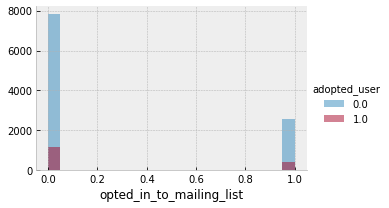

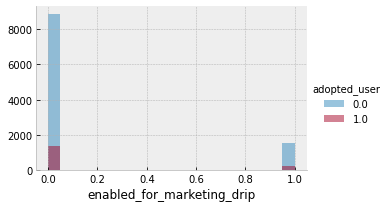

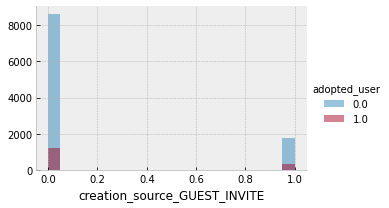

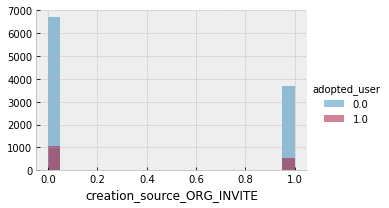

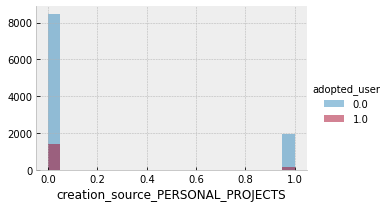

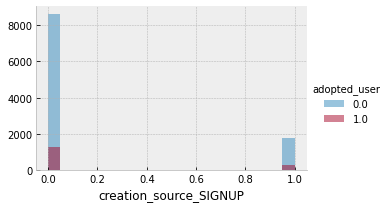

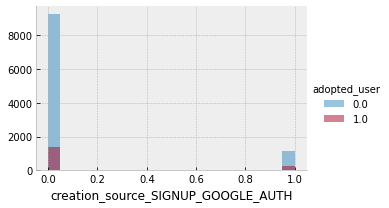

In [25]:
for col in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE',
           'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
           'creation_source_SIGNUP_GOOGLE_AUTH']:
    g = sns.FacetGrid(df_users, hue = "adopted_user", height=3, aspect=1.5,)
    g.map(plt.hist, col, alpha=.5, bins = 20)
    g.add_legend()    

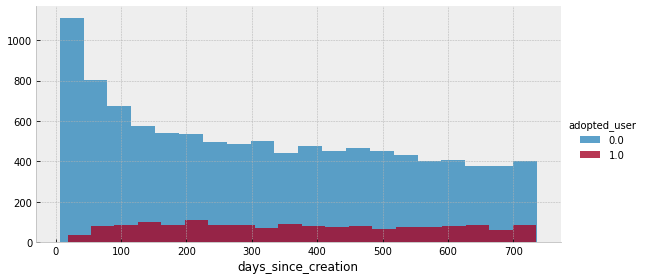

In [26]:
g = sns.FacetGrid(df_users, hue = "adopted_user", height=4, aspect=2,)
_ = g.map(plt.hist, 'days_since_creation', alpha=0.8, bins = 20)
_ = g.add_legend() 
#sns.distplot(df_users['days_since_creation'], kde = False, bins = 20, hue = 'adopted_user')

We can see that the adopted_user class is pretty unbalanced because only about 13% of the total 12000 users are adopted.

Let's try to fit Random Forest Regression model and find the feature importance. Since we will be using random forest using trees we don't need to scale any features.

In [27]:
# Importing necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score

In [28]:
def cv_optimize(model, parameters, Xtrain, ytrain, n_folds = 5):
    """
    Cross validation. Function to hypertune the model "model" with the input paramete distribution using
    "parameters" on the training data.
    The output will be the best estimator whose average score on all folds will be best. 
    """
    clf = GridSearchCV(model, param_grid = parameters, cv = n_folds, scoring = 'accuracy')
    t0 = time.time()
    clf.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print('\n\n\n=============================',type(model).__name__,'=================================\n')
    print("It takes %.3f seconds for tuning " % (time_fit))
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best
    
def do_classify(model, parameters, df, targetname, scale = True, cols_to_transform = 'numeric', 
                featurenames = 'all', train_size = 0.8):
      
    # Creating the X and y variables for our model
    if featurenames == 'all':
        X = df.drop([targetname], axis = 1)
    else:
        X = df[featurenames]
        
    y = df[targetname]
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)

    model = cv_optimize(model, parameters, Xtrain, ytrain)
    t0 = time.time()
    model = model.fit(Xtrain, ytrain)
    time_fit = time.time() - t0 
    print("It takes %.3f seconds for fitting" % (time_fit))
    training_accuracy = model.score(Xtrain, ytrain)
    test_accuracy = model.score(Xtest, ytest)
    precision = precision_score(ytest, model.predict(Xtest))
    recall = recall_score(ytest, model.predict(Xtest))
    AUC = roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])
            
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print("Precision on test data:    {:0.2f}".format(precision))
    print("Recall on test data:       {:0.2f}".format(recall))
    print("AUC on test data:          {:0.2f}".format(AUC))
    print("=======Confusion Matrix=========")
    print(confusion_matrix(ytest, model.predict(Xtest)))
    print("=======Classification report=======")
    print(classification_report(ytest, model.predict(Xtest)))
    print("="*100)
    print("="*100)
    print("="*100)
    return model, Xtrain, ytrain, Xtest, ytest

In [29]:
# Random Forest model
model_rf = RandomForestClassifier(class_weight='balanced') # adding balanced to handle the unbalanced data
parameters_rf = {
                 'n_estimators': [10, 25, 50, 75, 100],
                 'criterion': ["gini", "entropy"],
                 'max_depth': [3, 6, 10, 12],
                 'max_features': ['auto', 'sqrt']
                }

In [30]:
model_rf, Xtrain, ytrain, Xtest, ytest = do_classify(model_rf, parameters_rf, 
                                                                  df_users, targetname = 'adopted_user')




============================= RandomForestClassifier =================================

It takes 158.627 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}
It takes 1.239 seconds for fitting
Accuracy on training data: 0.82
Accuracy on test data:     0.69
Precision on test data:    0.16
Recall on test data:       0.35
AUC on test data:          0.62
=======Confusion Matrix=========
[[1558  550]
 [ 191  101]]
=======Classification report=======
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81      2108
         1.0       0.16      0.35      0.21       292

    accuracy                           0.69      2400
   macro avg       0.52      0.54      0.51      2400
weighted avg       0.80      0.69      0.74      2400



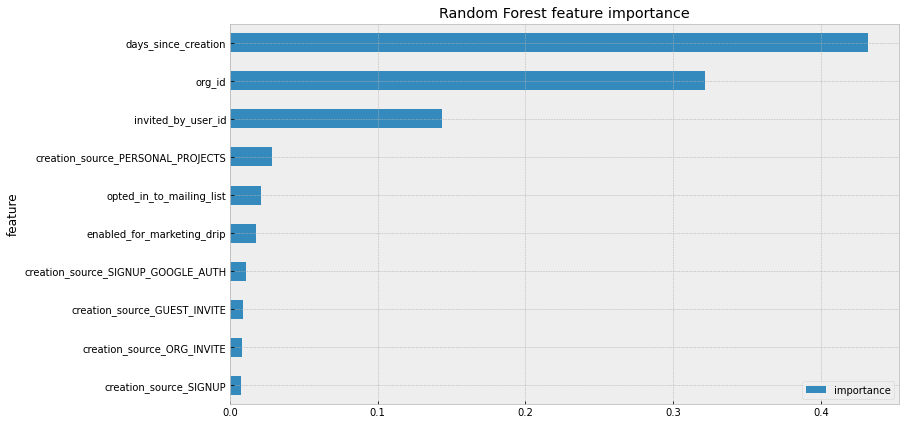

In [31]:
feat_imp = pd.DataFrame({'importance':model_rf.feature_importances_})    
feat_imp['feature'] = Xtrain.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))

**The top 5 important features seem to be:**

 - days_since_creation
 - org_id
 - invited_by_user_id
 - creation_source_PERSONAL_PROJECTS
 - opted_in_to_mailing_list

**Future possible work:** We can also add a feature which calculates the difference between the creation date of the account and the first login of the user.